In [1]:
import pandas as pd
import numpy as np # library to handle data in a vectorized manner
import geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude value
import folium # map rendering library
import re
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
# Importing some classifiers methods
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
# Metrics for classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [2]:
! pip install statsmodels --user
from statsmodels.stats.outliers_influence import variance_inflation_factor 
def variance_influence_factors(X,columns,vif_treshold):
        "Analysis of variance influence factors or colinearity"
        X=X.to_numpy()
        vif = pd.DataFrame()
        vif["features"] =columns
        X_vif=np.asarray(X[:,:])
        vif["VIF Factor"] = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]
        vif=np.asarray(vif)
        vif =dict(vif)
        vif_inverse={}
        for key,value in vif.items():
            vif_inverse[value]=key
        keys_ordered=[vif_inverse[name] for name in sorted(vif.values(),reverse=True)]
        vif_ordered=pd.DataFrame(index=keys_ordered,columns=['VIF Factor'])

        for key in keys_ordered:
            vif_ordered.loc[key,:]=vif[key]


        key_colinearity= vif_ordered.index[np.where(vif_ordered.iloc[:,0]>vif_treshold)]

        return vif_ordered,print("\n","The following features are collinears: "\
                     + ','.join(key for key in key_colinearity),"\n",sep="\n")

In [3]:
boroughs=pd.read_csv("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/Boroughs_london.csv",index_col=0)

In [4]:
neighbourhoods=pd.read_csv('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/neighbourhoods_london.csv',index_col=0)

In [5]:
London_neig_grouped_mean=pd.read_csv('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/london_neig_grouped_CATEGORY_mean.csv',index_col=0)

In [6]:
columns=London_neig_grouped_mean.columns[1:]

In [7]:
London_neig_grouped_mean['Favourite']=np.zeros(len(London_neig_grouped_mean.index)).astype(int)

In [8]:
places=[]
patterns=['https']
with open ("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/Most_visited_london.txt",'r') as f:
    line=f.readlines()
    for place in line:
        for pattern in patterns:
            if re.search(pattern, place):
                pass
            else:
                places.append(place.split('\n')[0].strip())
        
        

In [9]:
with open ("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/Other_visited_places.txt",'r') as f:
    line=f.readlines()
    for place in line:
           places.append(place.split('\n')[0].strip())         

In [10]:
print(places)

['Southbank', 'Bermondsey', 'Camden', 'Notting Hill', 'Peckham', 'Whitechapel', 'Kings Cross', 'Fitzrovia', 'Covent Garden', 'Elephant and Castle', 'City of London', 'Richmond', 'Greenwich', 'Shoreditch', 'Westminster', 'Mayfair', 'Shoreditch', 'Chelsea', 'Greenwich', 'Southwark', 'Brixton', 'Notting Hill', 'Camden', 'Soho', 'Kensington', 'City of London', 'Barnet', 'Camden', 'Hammersmith and Fulham', 'Kensington and Chelsea', 'Lambeth', 'Southwark', 'Westminster']


In [11]:
places=list(set(places))

In [12]:
place_not_neig=[]
for place in places:
    if place not in London_neig_grouped_mean['Neighbourhood'].values:
        place_not_neig.append(place)

In [13]:
place_not_neig=list(set(place_not_neig))
place_not_neig

['Hammersmith and Fulham',
 'Camden',
 'Barnet',
 'City of London',
 'Southwark',
 'Kensington and Chelsea']

In [14]:
place_neig=[x for x in places if x not in place_not_neig]

In [15]:
for place in place_not_neig:
    neig_list=neighbourhoods.loc[neighbourhoods.loc[:,'Borough'].values==place]['Neighbourhood'].values
    for neig in neig_list:
        place_neig.append(neig)


In [16]:
place_neig=list(set(place_neig))
len(place_neig)

105

In [17]:
print(place_neig)

['Elephant and Castle', "Shepherd's Bush", 'Friern Barnet', 'Barbican', 'Highgate', 'West Hampstead', 'Grahame Park', 'Holborn', 'Temple', 'Kensington', 'Brunswick Park', 'Whitechapel', 'West Kensington', 'East Dulwich', 'Walworth', 'Golders Green', 'North Kensington', 'Fulham', 'Wormwood Scrubs', 'Earls Court', 'Bermondsey', 'Colney Hatch', 'Peckham', 'Woodside Park', 'Monken Hadley', 'The Hyde', 'Temple Fortune', 'White City', 'Covent Garden', 'Cricklewood', 'Burroughs, The', 'Mayfair', 'Old Oak Common', 'South Kensington', 'The Hale', 'Chelsea', 'Kings Cross', 'Kilburn', 'Barnet (also Chipping Barnet, High Barnet)', 'West Hendon', 'East Barnet', 'Tufnell Park', 'Bloomsbury', 'Hendon', 'Holland Park', 'Richmond', 'Bankside', 'Camberwell', 'Notting Hill', 'Hammersmith', 'Kentish Town', 'Chalk Farm', 'Camden Town', 'Childs Hill', 'Finchley', 'Blackfriars', 'Aldgate', 'Surrey Quays', 'Totteridge', 'Westminster', 'Church End', 'Newington', 'Burnt Oak', 'Mill Hill', 'West Brompton', 'Gree

In [18]:
nice_places=pd.DataFrame(columns=['Neighbourhood','Latitude','Longitude'])

In [19]:
for place in place_neig:
        df1= neighbourhoods.loc[neighbourhoods.loc[:,'Neighbourhood'].values==place][['Neighbourhood','Latitude','Longitude']]
        nice_places=nice_places.append(df1,ignore_index=True)

In [20]:
nice_places=nice_places.drop_duplicates()

In [21]:
address = 'London,UK'

geolocator = Nominatim(user_agent="to_explorer",timeout=50)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Most Visited places in London using latitude and longitude values
map_london_most_visited = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng,place  in zip(nice_places['Latitude'],nice_places['Longitude'], nice_places['Neighbourhood']):
            label = '{}'.format(place)
            label = folium.Popup(label, parse_html=True)
            folium.RegularPolygonMarker(
                [lat, lng],
                rotation=70,
                radius=5,
                popup=label,
                color='magenta',
                fill=True,
                fill_color='white',
                #fill_color='#3186cc',
                fill_opacity=0.3,
                parse_html=False).add_to(map_london_most_visited)  
map_london_most_visited

In [22]:
map_london_most_visited.save("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/map_London_most_visited.html")

In [23]:
for ii in London_neig_grouped_mean.index:
    if London_neig_grouped_mean.loc[ii,'Neighbourhood'] in place_neig:
        London_neig_grouped_mean.loc[ii,'Favourite']=int(1.0)

In [24]:
london_data=London_neig_grouped_mean.drop(['Neighbourhood'],axis=1).values


In [25]:
London_neig_grouped_mean.columns[1:].to_list()

['arts_entertainment',
 'building',
 'education',
 'event',
 'food',
 'nightlife',
 'parks_outdoors',
 'shops',
 'travel',
 'Favourite']

In [26]:
type(london_data)
london_data=pd.DataFrame(london_data,index=london_data[:,0],columns=London_neig_grouped_mean.columns[1:].to_list())


In [27]:
london_data.columns

Index(['arts_entertainment', 'building', 'education', 'event', 'food',
       'nightlife', 'parks_outdoors', 'shops', 'travel', 'Favourite'],
      dtype='object')

In [28]:
testsize=0.24
X=london_data[london_data.columns[:-1]]
y=london_data[london_data.columns[-1]]


In [29]:
X.shape

(515, 9)

In [30]:
y.shape

(515,)

In [31]:
 X_train, X_test, Y_train, Y_test = train_test_split( \
            X, y, test_size=testsize, random_state=42,stratify=y)
        

In [32]:
print(X_train)

          arts_entertainment  building  education  event      food  nightlife  \
0.000000            0.000000  0.000000        0.0    0.0  0.928571   0.000000   
0.034091            0.034091  0.022727        0.0    0.0  0.625000   0.045455   
0.000000            0.000000  0.000000        0.0    0.0  0.214286   0.071429   
0.062500            0.062500  0.000000        0.0    0.0  0.312500   0.062500   
0.333333            0.333333  0.000000        0.0    0.0  0.000000   0.333333   
...                      ...       ...        ...    ...       ...        ...   
0.000000            0.000000  0.250000        0.0    0.0  0.250000   0.250000   
0.000000            0.000000  0.000000        0.0    0.0  0.200000   0.200000   
0.200000            0.200000  0.200000        0.0    0.0  0.200000   0.000000   
0.066667            0.066667  0.033333        0.0    0.0  0.533333   0.133333   
0.000000            0.000000  0.000000        0.0    0.0  0.571429   0.000000   

          parks_outdoors   

In [33]:
print(Y_train)

0.000000    1.0
0.034091    0.0
0.000000    0.0
0.062500    0.0
0.333333    1.0
           ... 
0.000000    0.0
0.000000    0.0
0.200000    1.0
0.066667    0.0
0.000000    0.0
Name: Favourite, Length: 360, dtype: float64


In [34]:
svm_model=svm.SVC(gamma='auto')
KNN_model = KNeighborsClassifier(n_neighbors=2)
LReg_model=LogisticRegression(solver='lbfgs')
LDA_model=LinearDiscriminantAnalysis()
Dtree_model=DecisionTreeClassifier(criterion='entropy', max_depth=3)
NB_model=GaussianNB()
models=[]
models.append('svm')
models.append('KNN')
models.append('Logistic Regresion')
models.append('Decision Tree')
models.append('NB')
models.append('LDA')


In [35]:
clf=[]
clf.append(svm_model.fit(X_train,Y_train))
clf.append(KNN_model.fit(X_train,Y_train))
clf.append(LReg_model.fit(X_train,Y_train))
clf.append(Dtree_model.fit(X_train,Y_train))
clf.append(NB_model.fit(X_train,Y_train))

In [36]:
variance_influence_factors(X_train,columns,0.5)



The following features are collinears: food,shops,nightlife,travel,arts_entertainment,parks_outdoors,building,event,education




(                   VIF Factor
 food                  1.94249
 shops                  1.6621
 nightlife              1.6105
 travel                1.29924
 arts_entertainment    1.28545
 parks_outdoors        1.23638
 building              1.12206
 event                 1.03291
 education              1.0154, None)

In [37]:
clf.append(LDA_model.fit(X_train[X_train.columns[:-1]],Y_train))

In [38]:
clf

[SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                      weights='uniform'),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        

In [39]:
y_pred=[]
for ii in range(len(clf)-1):
    y_pred.append(clf[ii].predict(X_test))
y_pred.append(clf[-1].predict(X_test[X_test.columns[:-1]]))

In [40]:
# Model Accuracy, how often is the classifier correct?
for ii in range(len(models)):
    print("Accuracy of "+ models[ii]+':',metrics.accuracy_score(Y_test, y_pred[ii]))

Accuracy of svm: 0.7935483870967742
Accuracy of KNN: 0.7677419354838709
Accuracy of Logistic Regresion: 0.7935483870967742
Accuracy of Decision Tree: 0.7032258064516129
Accuracy of NB: 0.2838709677419355
Accuracy of LDA: 0.7870967741935484


In [41]:
# ROC_AUC_SCORE
for ii in range(len(models)):
    print("ROC_AUC_SCORE of "+ models[ii]+':',metrics.roc_auc_score(Y_test, y_pred[ii]))

ROC_AUC_SCORE of svm: 0.5
ROC_AUC_SCORE of KNN: 0.506859756097561
ROC_AUC_SCORE of Logistic Regresion: 0.5
ROC_AUC_SCORE of Decision Tree: 0.5124491869918699
ROC_AUC_SCORE of NB: 0.5141006097560976
ROC_AUC_SCORE of LDA: 0.507494918699187


In [42]:
#Confusion matrix
from matplotlib.colors import LinearSegmentedColormap

def plot_confusion_matrix(Title,models,Y_test,y_pred,labels,nrows,ncols):
   
    test=np.where(Y_test==1,labels[0],labels[1]).tolist()
    cm=[]
    for ii in range(len(models)):
        pred=np.where(y_pred[ii]==1,labels[0],labels[1]).tolist()
        cm.append(confusion_matrix(test, pred, labels))
    print(cm)
    colors = [(0.75, 0.5, 1), (0, 1, 0), (1, 0, 0)]  # B -> G -> R
    n_bins = [3, 6, 15,30,60,100]  # Discretizes the interpolation into bins
    cmap_name = 'my_list'
    
    fig,axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
    fig.set_canvas(plt.gcf().canvas)   

    for ii,n_bin,axt in zip(range(len(models)),n_bins,axs.ravel()):
            # Create the colormap
            cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
            cax = axt.matshow(cm[ii],cmap=cmap)
            
            axt.set_xticklabels([''] + labels)
            axt.set_yticklabels([''] + labels)
            axt.set_xlabel('Predicted')
            axt.set_ylabel('True')
            axt.set_title(models[ii])
            fig.colorbar(cax,ax=axt)
            
              
    plt.suptitle(Title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    savefig=Title + '.png'
    return fig.savefig(savefig),plt.show()


[array([[  0,  32],
       [  0, 123]]), array([[  2,  30],
       [  6, 117]]), array([[  0,  32],
       [  0, 123]]), array([[  6,  26],
       [ 20, 103]]), array([[ 29,   3],
       [108,  15]]), array([[  1,  31],
       [  2, 121]])]


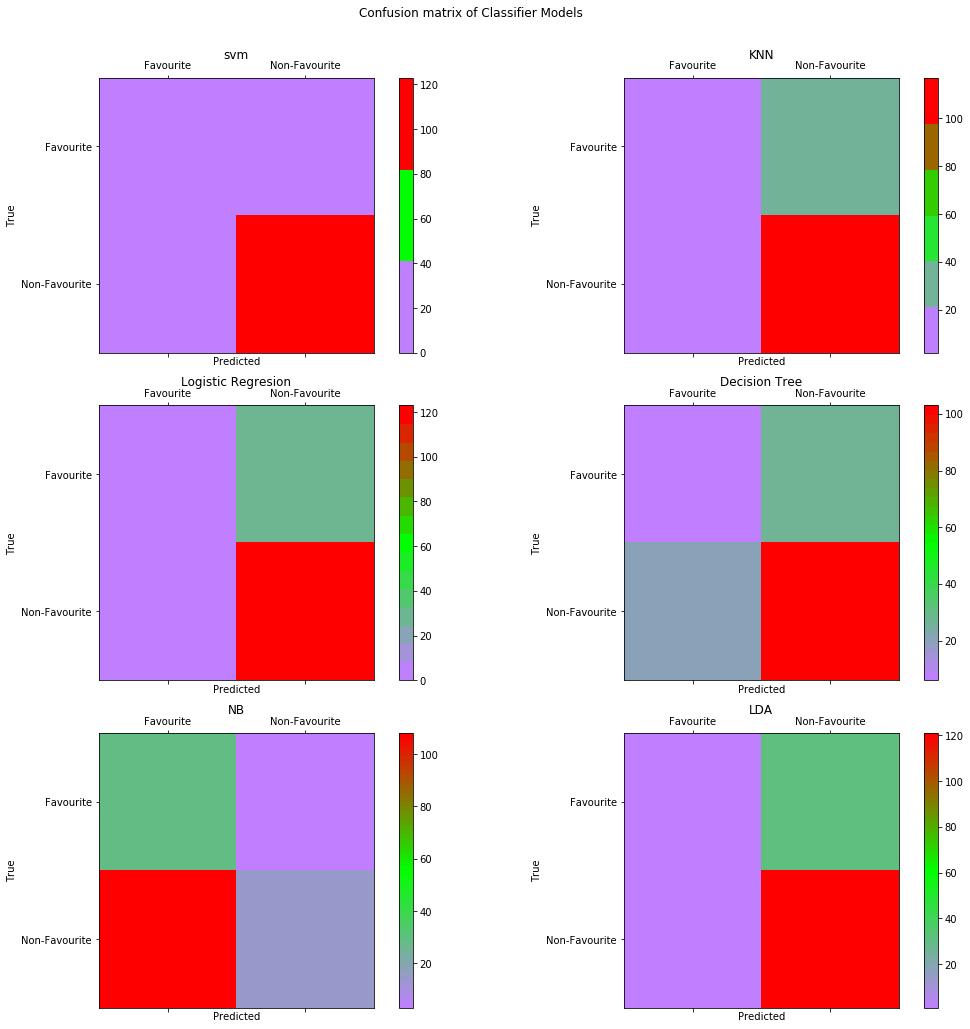

(None, None)

In [43]:
labels = ['Favourite', 'Non-Favourite']
Title='Confusion matrix of Classifier Models'
nrows=3
ncols=2
plot_confusion_matrix(Title,models,Y_test,y_pred,labels,nrows,ncols)

In [44]:
#!pip install graphviz --user
#!pip install pydotplus --user

In [45]:
#Visualizing Decision Trees
#! pip install six --user
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf[3], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = columns,class_names=['Non-Favourite','Favourite'])
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('London_classifiers.png')
#Image(graph.create_png())

In [46]:
#! pip install tensorflow keras --user

In [2]:
import tensorflow as tf

In [3]:
from keras.layers import Dense

Using TensorFlow backend.


In [4]:
from keras.models import Model

In [5]:
tf.keras.backend.set_floatx('float64')

In [6]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 =Dense(32, input_dim=9)
    self.d2 = Dense(12, activation='relu')
    self.d3 = Dense(1, activation='sigmoid')

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.d3(x)

# Create an instance of the model
model = MyModel()

Choose an optimizer and loss function for training:

In [7]:

dir(tf.keras.losses)

['BinaryCrossentropy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'Hinge',
 'Huber',
 'KLD',
 'KLDivergence',
 'LogCosh',
 'Loss',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'Poisson',
 'Reduction',
 'SparseCategoricalCrossentropy',
 'SquaredHinge',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'binary_crossentropy',
 'categorical_crossentropy',
 'categorical_hinge',
 'cosine_similarity',
 'deserialize',
 'get',
 'hinge',
 'kld',
 'kullback_leibler_divergence',
 'logcosh',
 'mae',
 'mape',
 'mean_absolute_error',
 'mean_absolute_percentage_error',
 'mean_squared_error',
 'mean_squared_logarithmic_error',
 'mse',
 'msle',
 'poisson',
 'serialize',
 'sparse_categorical_crossentropy',
 'squared_hinge']

In [8]:
loss_object = tf.keras.losses.BinaryCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [9]:
dir(tf.keras.metrics)

['AUC',
 'Accuracy',
 'BinaryAccuracy',
 'BinaryCrossentropy',
 'CategoricalAccuracy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'FalseNegatives',
 'FalsePositives',
 'Hinge',
 'KLD',
 'KLDivergence',
 'LogCoshError',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'Mean',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanIoU',
 'MeanRelativeError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'MeanTensor',
 'Metric',
 'Poisson',
 'Precision',
 'Recall',
 'RootMeanSquaredError',
 'SensitivityAtSpecificity',
 'SparseCategoricalAccuracy',
 'SparseCategoricalCrossentropy',
 'SparseTopKCategoricalAccuracy',
 'SpecificityAtSensitivity',
 'SquaredHinge',
 'Sum',
 'TopKCategoricalAccuracy',
 'TrueNegatives',
 'TruePositives',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'binary_accuracy',
 'binary_crossentropy',
 'categorical_accuracy',
 'categorical_crossentropy',
 '

Metrics

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
#train_cross_accuracy = tf.keras.metrics.BinaryCrossentropy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
#test_cross_accuracy = tf.keras.metrics.BinaryCrossentropy(name='train_accuracy')

Gradient

In [11]:
@tf.function
def train_step(features, labels):
  with tf.GradientTape() as tape:
    predictions = model(features)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

Test the model

In [12]:
@tf.function
def test_step(features, labels):
  predictions = model(features)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [13]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Favourite')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
batch_size = 2
import pandas as pd

london_data=pd.read_csv('/home/sedna/Downloads/london_data.csv',index_col=0)
testsize=0.3
from sklearn.model_selection import train_test_split
train,test= train_test_split(london_data,test_size=testsize)
train_ds = df_to_dataset(train,batch_size=batch_size)
test_ds = df_to_dataset(test,batch_size=batch_size)

In [ ]:


EPOCHS = 5


for epoch in range(EPOCHS):
  for features, labels in train_ds:
      train_step(features, labels)

  for test_featues, test_labels in test_ds:
      test_step(test_featues, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()